In [2]:
import pandas as pd
import html
#nltk.download() #only for the first time running it
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import json
import regex as re
from textblob import TextBlob
import numpy

import networkx as nx


In [6]:
#create dataframe on media posts USE FOR ALL DATA - Don't run now
def createDataFrame():  
    with open("C:/Users/Administrator/Desktop/tweets.jsonl", encoding='utf8') as f:
        for line in f:
            row = json.loads(line)
            try:
                yield (row['author_id'],
                        row['in_reply_to_user_id'],
                        row['text'],
                        row['public_metrics']['retweet_count'],
                        row['public_metrics']['quote_count'],
                        row['public_metrics']['reply_count'],
                        row['public_metrics']['like_count'])
            except KeyError:
                pass

#create csv
df = pd.DataFrame(createDataFrame())
df.columns =['author_id', 'in_reply_to_user_id', 'text',  'retweet_count', 'quote_count', 'reply_count', 'like_count']
df.to_json('datain/nft_tweets.jsonl', orient='records', index=True, lines= True)
output = pd.read_json("datain/nft_tweets.jsonl", lines = True)
output['total'] = output[['retweet_count', 'quote_count','reply_count', 'like_count']].sum(axis=1)
#sort by highest total
output = output.sort_values(by = 'total', ascending = False)
#top 100
# output = output.head(100)
output.to_json('datain/all_data.jsonl', orient='records', index=True, lines= True)

In [ ]:
#import the data
data = pd.read_json("datain/nft_top_100_tweets.jsonl", lines=True)

In [6]:

all_data = pd.read_json("datain/all_data.jsonl", lines=True)

In [7]:
#prep stop words
stop_words = stopwords.words('english')
stop_words.append('rt')
stop_words.append('nft')
# stop_words.append('#nft')

#function for cleaning a tweet (remove mentions, hashtags, links, html entities, stop words. And make sure it's only letters)
def clean_tweet(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        tweet = str.lower(tweet)
        # tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
        tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)|(#[A-Za-z0-9_]+)", " ", tweet).split()) # remove mentions and hashtags
        # tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)", " ", tweet).split())
        tweet = re.sub("(http\S+|http)", "", tweet, flags=re.MULTILINE) # remove links
        tweet = re.sub('\&\w+', "", tweet) # remove html entities
        tweet = re.sub('[^a-zA-Z# ]+', ' ', tweet) # make sure tweet is only letters
        # stem & remove stop words
        # tweet = ' '.join([PorterStemmer().stem(word=word) for word in tweet.split() if word not in stop_words])
        tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
        return tweet

#clean data
for i in all_data.index:
    text = all_data["text"][i]
    cleaned_text = clean_tweet(text)
    cleaned_text = html.unescape(cleaned_text)
    all_data["text"][i] = cleaned_text

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
tweets.to_json('datain/nft_search_tweets_sample_cleaned.jsonl', orient='records', index=True, lines= True)

In [ ]:
tweet_text = sample_data['text'].str.cat(sep=' ')
tokens = nltk.word_tokenize(tweet_text)
most_common = pd.DataFrame(nltk.ngrams(tokens, 1)).value_counts().to_frame()
# terms_count = term_data['text'].value_counts().to_dict()
# terms_count = pd.DataFrame.from_dict(terms_count, orient='index')

# terms_count.to_html("dataout/terms_count.html")

most_common.to_html('dataout/term_freq.html')

In [8]:
#nft_top_100_sentiment <- Has interactions and sentiment totals
positivity = ''
output = pd.read_json("datain/all_data.jsonl", lines = True)
def getSentiment():
    for i in output.index:
        row = TextBlob(output.iloc[i]['text'])
        if row.sentiment.polarity >= 0.7:
                positivity = 'mostly_positive'
        elif row.sentiment.polarity <= -0.7:
            positivity = 'mostly_negative'
        elif row.sentiment.polarity > -0.7 and row.sentiment.polarity < -0.4:
            positivity = 'negative'
        elif row.sentiment.polarity > 0.4 and row.sentiment.polarity < 0.7:
                positivity = 'positive'
        else:
            positivity = 'nuetral'
        yield  row.sentiment.polarity, row.sentiment.subjectivity, positivity
        
df = pd.DataFrame(getSentiment())
df.columns =['polarity', 'subjectivity', 'positivity']
output['polarity'] = df['polarity']
output['subjectivity'] = df['subjectivity']
output['positivity'] = df['positivity']
output.to_json('datain/nft_cleaned_interactions_sentiment.jsonl', orient='records', index=True, lines= True)

In [ ]:
# Word cloud of top 100 NFT's
top_100_word_cloud = pd.read_json("datain/nft_top_100_cleaned_interactions_sentiment.jsonl", lines=True)
# Generate a word cloud image
stopwords = set(STOPWORDS)
stopwords.update(("t", "co", "https", "t", "amp", "RT"))
wordcloud = WordCloud(stopwords=stopwords,background_color='white', max_words=1000,contour_color='#023075',contour_width=3,colormap='rainbow').generate(' '.join(top_100_word_cloud['text']))
# create image as cloud
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# store to file
plt.savefig("cloud.png", format="png")
plt.show()

In [ ]:
# Comment sentiment
#### Read from nft_search_tweets_sample - need replied to with text and author
#### Original Poster
def createOriginalDataFrame():  
    with open("datain/nft_search_tweets_sample.jsonl", encoding='utf8') as f:
        for line in f:
            row = json.loads(line)
            try:
                if row["lang"] == 'en'and len(row.get('referenced_tweets', [])) == 0:
                    yield (row['id'],
                            row['text'],
                            row['author_id'],
                            row['public_metrics']['retweet_count'],
                            row['public_metrics']['quote_count'],
                            row['public_metrics']['reply_count'],
                            row['public_metrics']['like_count'],
                            row['attachments']['media_keys'],
                            row['created_at']
                    )
            except KeyError:
                pass

def createRepliesDataFrame():  
    with open("datain/nft_search_tweets_sample.jsonl", encoding='utf8') as f:
        for line in f:
            row = json.loads(line)
            try:
                if row["lang"] == 'en'and len(row.get('referenced_tweets', [])) != 0:
                    yield (row['id'],
                            row['text'],
                            row['author_id'],
                            row['in_reply_to_user_id'],
                            row['public_metrics']['retweet_count'],
                            row['public_metrics']['quote_count'],
                            row['public_metrics']['reply_count'],
                            row['public_metrics']['like_count'],
                            row['attachments']['media_keys'],
                            row['created_at']
                    )
            except KeyError:
                pass
#create csv
original_data = pd.DataFrame(createOriginalDataFrame())
original_data.columns =['id', 'text', 'in_reply_to_user_id', 'retweet_count', 'quote_count', 'reply_count', 'like_count', 'media_keys', 'created_at']
original_data.to_json('datain/nft_original_tweets.jsonl', orient='records', index=True, lines= True)
original_data['total'] = original_data[['retweet_count', 'quote_count','reply_count', 'like_count']].sum(axis=1)

replies_data = pd.DataFrame(createRepliesDataFrame())
replies_data.columns =['id', 'text', 'reply_author_id', 'in_reply_to_user_id', 'retweet_count', 'quote_count', 'reply_count', 'like_count', 'media_keys', 'created_at']
replies_data.to_json('datain/nft_replies_tweets.jsonl', orient='records', index=True, lines= True)
replies_data['total'] = replies_data[['retweet_count', 'quote_count','reply_count', 'like_count']].sum(axis=1)

In [ ]:
original_data.reindex()
replies_data.reindex()

all_data = pd.merge(original_data, replies_data, on='in_reply_to_user_id').dropna()

# replies_data['matched_id'] = pd.Series((original_data.original_author_id.isin(replies_data.reply_author_id)))

In [10]:
def getSentiment():
    for i in output.index:
        row = TextBlob(output.iloc[i]['text'])
        if row.sentiment.polarity >= 0.7:
                positivity = 'mostly_positive'
        elif row.sentiment.polarity <= -0.7:
            positivity = 'mostly_negative'
        elif row.sentiment.polarity > -0.7 and row.sentiment.polarity < -0.4:
            positivity = 'negative'
        elif row.sentiment.polarity > 0.4 and row.sentiment.polarity < 0.7:
                positivity = 'positive'
        else:
            positivity = 'nuetral'
        yield  row.sentiment.polarity, row.sentiment.subjectivity, positivity
    # with open("datain/cleaned.txt", encoding='utf8') as f:
    #     for line in f:
    #         row = TextBlob(line)
    #         if row.sentiment.polarity >= 0.7:
    #             positivity = 'mostly_positive'
    #         elif row.sentiment.polarity <= -0.7:
    #             positivity = 'mostly_negative'
    #         elif row.sentiment.polarity > -0.7 and row.sentiment.polarity < -0.4:
    #             positivity = 'negative'
    #         elif row.sentiment.polarity > 0.4 and row.sentiment.polarity < 0.7:
    #              positivity = 'positive'
    #         else:
    #             positivity = 'nuetral'
    #         yield line, row.sentiment.polarity, row.sentiment.subjectivity, positivity
df = pd.DataFrame(getSentiment())
df.columns =['polarity', 'subjectivity', 'positivity']
output['polarity'] = df['polarity']
output['subjectivity'] = df['subjectivity']
output['positivity'] = df['positivity']
output.to_json('datain/all_matched_author_replied_sentiment.jsonl', orient='records', index=True, lines= True)

In [ ]:
def createTagDataFrame():  
    with open("datain/nft_search_tweets_sample.jsonl", encoding='utf8') as f:
        for line in f:
            row = json.loads(line)
            try:
                if row["lang"] == 'en' and len(row.get('entities', ['hashtags'])) != 0:
                    yield (row['id'],
                            row['text'],
                            row['entities']['hashtags'])
            except KeyError:
                pass
#create csv
tag_data = pd.DataFrame(createTagDataFrame())
tag_data.columns =['id', 'text', 'hashtags']
new_df = pd.concat([pd.DataFrame(pd.json_normalize(x)) for x in tag_data['hashtags']],ignore_index=True)

tags_count = new_df['tag'].value_counts().to_dict()
counts = pd.DataFrame.from_dict(tags_count, orient='index')


In [ ]:
plt.bar()

In [ ]:
interactions_sentiment_df = pd.read_json('datain/matched_author_replied_sentiment.jsonl', lines=True)
interactions_sentiment_df['created_at_x'] = interactions_sentiment_df['created_at_x'].astype('datetime64[ns]')
interactions_sentiment_df['created_at_y'] = interactions_sentiment_df['created_at_y'].astype('datetime64[ns]')

In [ ]:
#interactions vs time
interactions_sentiment_df.sort_values(by = 'created_at_x', ascending = False)
plt.bar(interactions_sentiment_df['created_at_x'].dt.hour, interactions_sentiment_df['total_x'])

In [ ]:
#Node user
#Edge from - to.
# all_data['id_x']
all_data = pd.read_json('datain/matched_author_replied_sentiment.jsonl', lines=True)
# all_data['id_y']

G = nx.from_pandas_edgelist(tweets.head(10000), 'author_id', 'in_reply_to_user_id') #Turn df into graph
pos = nx.spring_layout(G) #specify layout for visual

f, ax = plt.subplots(figsize=(25, 25))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)


In [ ]:
G.number_of_edges()

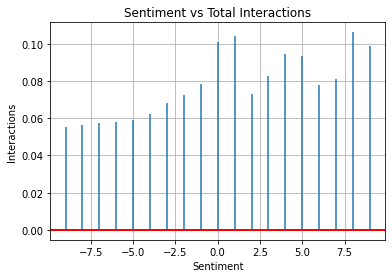

In [11]:
#total vs polarity corr
lines = plt.xcorr(output['polarity'], output['total'], maxlags=9, usevlines=True)

plt.title('Sentiment vs Total Interactions')

plt.xlabel('Sentiment')

plt.ylabel('Interactions')    

plt.grid(True)

plt.axhline(0, color='red', lw=2)

plt.show()

#Does this mean no correlation?

-0.08394383554122467

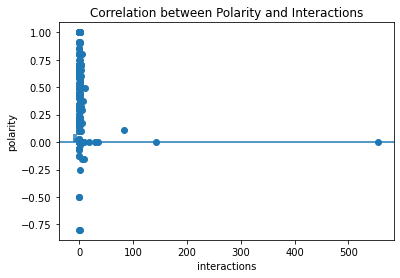

In [16]:
# adds the title
plt.title('Correlation between Polarity and Interactions')
  
# plot the data
plt.scatter(output['total'], output['polarity'])
  
# fits the best fitting line to the data
plt.xcorr(output['total'], output['polarity'])
  
# Labelling axes
plt.xlabel('interactions')
plt.ylabel('polarity')

output["total"].corr(output["polarity"])

0.6534200912236265

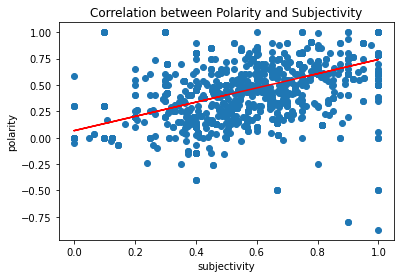

In [12]:

# adds the title
plt.title('Correlation between Polarity and Subjectivity') 
  
# fits the best fitting line to the data
theta = numpy.polyfit(output['subjectivity'], output['polarity'], 1)
y_line = theta[1] + theta[0] * output['subjectivity']
plt.scatter(output['subjectivity'], output['polarity'])  
plt.plot(output['subjectivity'], y_line, 'r')
# Labelling axes
plt.xlabel('subjectivity')
plt.ylabel('polarity')


output["polarity"].corr(output["subjectivity"])

0.0231167642932114

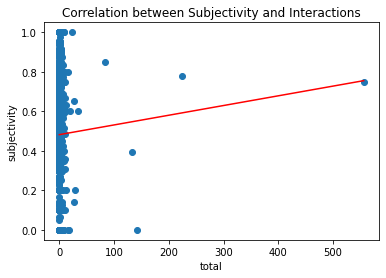

In [13]:
# adds the title
plt.title('Correlation between Subjectivity and Interactions') 
  
# fits the best fitting line to the data
theta = numpy.polyfit(output['total'], output['subjectivity'], 1)
y_line = theta[1] + theta[0] * output['total']
plt.scatter(output['total'], output['subjectivity'])  
plt.plot(output['total'], y_line, 'r')
# Labelling axes
plt.xlabel('total')
plt.ylabel('subjectivity')
output["total"].corr(output["subjectivity"])

In [ ]:
sentiment_vs_interactions = pd.read_json('datain/nft_top_100_cleaned_interactions_sentiment.jsonl', lines=True)

df_expected = pd.concat([sentiment_vs_interactions, sentiment_vs_interactions['hashtags'].apply(pd.Series)], axis = 1).drop('hashtags', axis = 1)
tag_array = []
tags_array = []

for j in range(100):
    for i in range(13):
        try:
            tag_array.append(df_expected.iloc[j][i].get('tag'))
        except:
            pass
    tags_array.append([tag_array])
    tag_array = []
df_expected['tags'] = tags_array
df_expected.drop(df_expected.columns[[11,12,13,14,15,16,17,18,19,20,21,22,23]], axis=1, inplace=True)

df_expected.to_json('datain/flattened_tags.jsonl')

In [14]:
#add weight to tags with most interactions
#tags are case sensitive

tweets = pd.read_json('C:/Users/Administrator/Desktop/tweets.jsonl', lines=True)